In [24]:
import pandas as pd
import re

import utils
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn-colorblind')

In [69]:
# Params
grid_size = 'hex_grid_1000'

year_train = '2000'
year_test = '2005'
model_type = 'RandomForest'

metrics = ['recall@', 'recall ch@', 'precision@', 'precision ch@', 'cost_loss@', 'savings@', 'f1@', 'f1 ch@']

In [76]:
def gen_cases(metrics):
    cases = []
    for metric in metrics:
        new_name = metric.replace(" ", "_").replace('@', '')
        cases.append("max(CASE WHEN metric = '{0}' then value else null END) as {1}".format(metric,new_name))
    return ", ".join(cases)

def results_table_by_forest(metrics, grid_size, year_train, year_test, model_type):
    cases = gen_cases(metrics)
    query = (""" SELECT model_id,
                   model_type,
                   model_parameters -> 'n_estimators' AS n_estimators,
                   model_parameters -> 'min_samples_split' AS min_samples_split,
                   model_parameters -> 'max_depth' AS max_depth,
                   model_parameters -> 'max_features' AS max_features,
                   year_test,
                   cutoff,
                   {cases}
             FROM results.evaluations e
             JOIN results.models m
             USING(model_id)
                 WHERE year_test = {test}
                 and model_id = 79
                 AND year_train = '{train}'
                 AND grid_size = '{grid_size}'  
                 AND model_type = '{model_type}'
              GROUP BY model_id, model_type, model_parameters, year_test, cutoff
        """.format(cases = cases,
                   test = year_test,
                   train = year_train,
                   grid_size = grid_size,
                   model_type = model_type))

    db_engine = utils.get_connection()
    data = pd.read_sql(query, db_engine)   
    return data

In [77]:
res = results_table_by_forest(metrics, grid_size, year_train, year_test, model_type)
res['cutoff'] = res['cutoff'].map(float)

In [78]:
res.head()

,model_id,model_type,n_estimators,min_samples_split,max_depth,max_features,year_test,cutoff,recall,recall_ch,precision,precision_ch,cost_loss,savings,f1,f1_ch
0,79,RandomForest,10,10,10,5,2005,0.10,0.985714,0.945946,0.901961,0.700000,39358.0,0.502911,0.941980,0.804598
1,79,RandomForest,10,10,10,5,2005,0.15,0.976190,0.909910,0.940367,0.795276,34697.1,0.561777,0.957944,0.848740
2,79,RandomForest,10,10,10,5,2005,0.20,0.959524,0.846847,0.954976,0.831858,34174.8,0.568375,0.957245,0.839286
3,79,RandomForest,10,10,10,5,2005,0.25,0.952381,0.819820,0.968523,0.875000,33223.5,0.580389,0.960384,0.846512
4,79,RandomForest,10,10,10,5,2005,0.30,0.933333,0.747748,0.970297,0.873684,37142.5,0.530892,0.951456,0.805825


In [79]:
def plot_grid(min_samples_split,
              max_depth,
              max_features,
              n_estimators,
              metric,
              grid):
    
    fig, ax = plt.subplots(figsize=(7, 3))
    
    if grid == 'n_estimators':
        res_sub = res[(res['min_samples_split'] == min_samples_split) &
              (res['max_features'] == max_features) &
              (res['max_depth'] == max_depth)]
    elif grid == 'max_features':
        res_sub = res[(res['min_samples_split'] == min_samples_split) &
              (res['n_estimators'] == n_estimators) &
              (res['max_depth'] == max_depth)]
    elif grid == 'max_depth':
        res_sub = res[(res['min_samples_split'] == min_samples_split) &
              (res['n_estimators'] == n_estimators) &
              (res['max_features'] == max_features)]
    elif grid == 'min_samples_split':
        res_sub = res[(res['max_depth'] == max_depth) &
              (res['n_estimators'] == n_estimators) &
              (res['max_features'] == max_features)]
    else:
        return None
    
    for n in res_sub[grid].unique():
        ax.plot(res_sub[res_sub[grid]== n]['cutoff'], 
                res_sub[res_sub[grid]== n][metric], 
                label='{} {}'.format(metric,n), alpha = 0.7)
    #ax.set_ylim([0,1])
    ax.legend()


/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


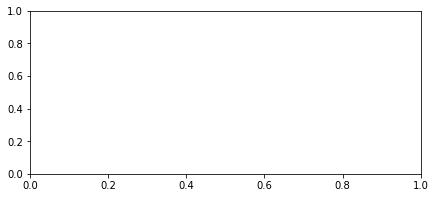

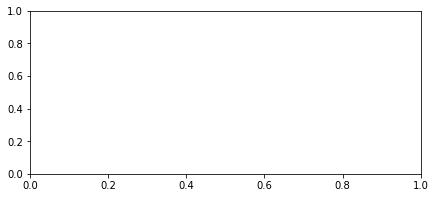

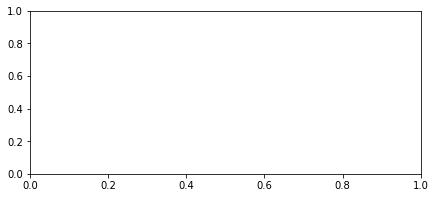

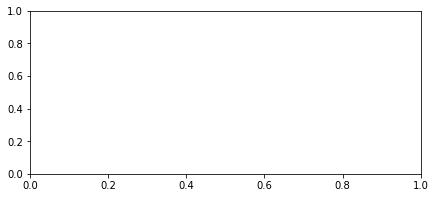

In [80]:
min_samples_split = 5
max_depth = 5
max_features = 10
n_estimators = 1000
metric = 'f1'

plot_grid(min_samples_split,
              max_depth,
              max_features,
              n_estimators,
              metric,
              'n_estimators')

plot_grid(min_samples_split,
              max_depth,
              max_features,
              n_estimators,
              metric,
              'max_depth')

plot_grid(min_samples_split,
              max_depth,
              max_features,
              n_estimators,
              metric,
              'min_samples_split')

plot_grid(min_samples_split,
              max_depth,
              max_features,
              n_estimators,
              metric,
              'max_features')

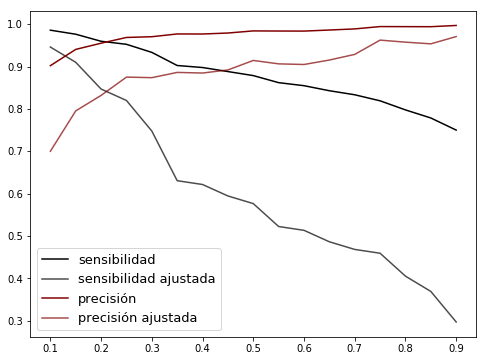

In [90]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(res['cutoff'], res['recall'], 'C1', label='sensibilidad', color='black')
ax.plot(res['cutoff'], res['recall_ch'], 'C2', label='sensibilidad ajustada', color='black', alpha = .7)
ax.plot(res['cutoff'], res['precision'], 'C3', label='precisión', color='maroon')
ax.plot(res['cutoff'], res['precision_ch'], 'C4', label='precisión ajustada', color='maroon', alpha=.7)
#ax.plot(res['cutoff'], res['f1'], 'C5', label='f1')
#ax.plot(res['cutoff'], res['f1_ch'], 'C6', label='f1 ch')
ax.legend(loc=3, prop={'size': 13})

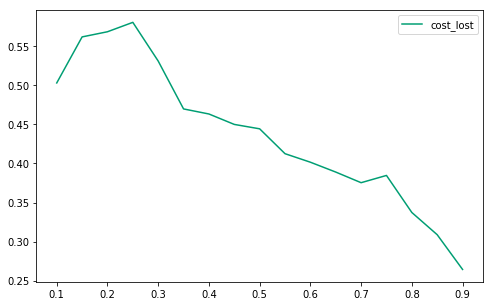

In [82]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(res['cutoff'], res['savings'], 'C1', label='cost_lost')
ax.legend()

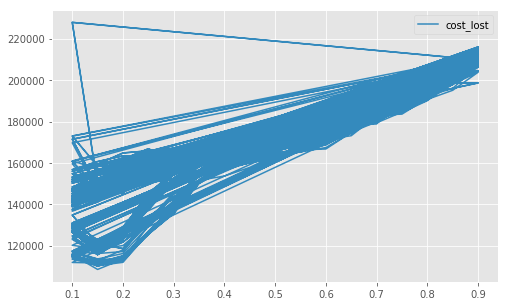

In [10]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(res['cutoff'], res['cost_loss'], 'C1', label='cost_lost')
ax.legend()

In [23]:
res2 = res[(res['cutoff'] > .25) & (res['n_estimators'] > 10)]

In [24]:
res2.sort_values(by='recall', ascending=False).head()

,model_id,model_type,n_estimators,min_samples_split,max_depth,max_features,year_test,cutoff,recall,recall_ch,precision,precision_ch,cost_loss,savings,f1,f1_ch
412,500,RandomForest,500,2,5,10,2005,0.3,0.915935,0.625698,0.964970,0.811594,137844.0,0.424939,0.939813,0.706625
684,516,RandomForest,5000,10,5,10,2005,0.3,0.915935,0.625698,0.964970,0.811594,136601.0,0.430128,0.939813,0.706625
650,514,RandomForest,500,10,5,10,2005,0.3,0.915935,0.625698,0.966247,0.817518,135491.0,0.434755,0.940419,0.708861
701,517,RandomForest,10000,10,5,10,2005,0.3,0.915935,0.625698,0.964970,0.811594,135862.0,0.433208,0.939813,0.706625
463,503,RandomForest,10000,2,5,10,2005,0.3,0.915935,0.625698,0.964970,0.811594,135862.0,0.433208,0.939813,0.706625


In [25]:
res2.sort_values(by='recall_ch', ascending=False).head()

,model_id,model_type,n_estimators,min_samples_split,max_depth,max_features,year_test,cutoff,recall,recall_ch,precision,precision_ch,cost_loss,savings,f1,f1_ch
412,500,RandomForest,500,2,5,10,2005,0.3,0.915935,0.625698,0.964970,0.811594,137844.0,0.424939,0.939813,0.706625
684,516,RandomForest,5000,10,5,10,2005,0.3,0.915935,0.625698,0.964970,0.811594,136601.0,0.430128,0.939813,0.706625
650,514,RandomForest,500,10,5,10,2005,0.3,0.915935,0.625698,0.966247,0.817518,135491.0,0.434755,0.940419,0.708861
701,517,RandomForest,10000,10,5,10,2005,0.3,0.915935,0.625698,0.964970,0.811594,135862.0,0.433208,0.939813,0.706625
463,503,RandomForest,10000,2,5,10,2005,0.3,0.915935,0.625698,0.964970,0.811594,135862.0,0.433208,0.939813,0.706625


In [26]:
res2.sort_values(by='f1', ascending=False).head()

,model_id,model_type,n_estimators,min_samples_split,max_depth,max_features,year_test,cutoff,recall,recall_ch,precision,precision_ch,cost_loss,savings,f1,f1_ch
650,514,RandomForest,500,10,5,10,2005,0.3,0.915935,0.625698,0.966247,0.817518,135491.0,0.434755,0.940419,0.708861
701,517,RandomForest,10000,10,5,10,2005,0.3,0.915935,0.625698,0.964970,0.811594,135862.0,0.433208,0.939813,0.706625
684,516,RandomForest,5000,10,5,10,2005,0.3,0.915935,0.625698,0.964970,0.811594,136601.0,0.430128,0.939813,0.706625
582,510,RandomForest,10000,5,5,10,2005,0.3,0.915935,0.625698,0.964970,0.811594,135862.0,0.433208,0.939813,0.706625
463,503,RandomForest,10000,2,5,10,2005,0.3,0.915935,0.625698,0.964970,0.811594,135862.0,0.433208,0.939813,0.706625


In [27]:
res2.sort_values(by='f1_ch', ascending=False).head()

,model_id,model_type,n_estimators,min_samples_split,max_depth,max_features,year_test,cutoff,recall,recall_ch,precision,precision_ch,cost_loss,savings,f1,f1_ch
650,514,RandomForest,500,10,5,10,2005,0.3,0.915935,0.625698,0.966247,0.817518,135491.0,0.434755,0.940419,0.708861
684,516,RandomForest,5000,10,5,10,2005,0.3,0.915935,0.625698,0.964970,0.811594,136601.0,0.430128,0.939813,0.706625
701,517,RandomForest,10000,10,5,10,2005,0.3,0.915935,0.625698,0.964970,0.811594,135862.0,0.433208,0.939813,0.706625
582,510,RandomForest,10000,5,5,10,2005,0.3,0.915935,0.625698,0.964970,0.811594,135862.0,0.433208,0.939813,0.706625
412,500,RandomForest,500,2,5,10,2005,0.3,0.915935,0.625698,0.964970,0.811594,137844.0,0.424939,0.939813,0.706625


In [28]:
res2.sort_values(by='cost_loss', ascending=True).head()

,model_id,model_type,n_estimators,min_samples_split,max_depth,max_features,year_test,cutoff,recall,recall_ch,precision,precision_ch,cost_loss,savings,f1,f1_ch
650,514,RandomForest,500,10,5,10,2005,0.3,0.915935,0.625698,0.966247,0.817518,135491.0,0.434755,0.940419,0.708861
463,503,RandomForest,10000,2,5,10,2005,0.3,0.915935,0.625698,0.964970,0.811594,135862.0,0.433208,0.939813,0.706625
582,510,RandomForest,10000,5,5,10,2005,0.3,0.915935,0.625698,0.964970,0.811594,135862.0,0.433208,0.939813,0.706625
701,517,RandomForest,10000,10,5,10,2005,0.3,0.915935,0.625698,0.964970,0.811594,135862.0,0.433208,0.939813,0.706625
446,502,RandomForest,5000,2,5,10,2005,0.3,0.915307,0.622905,0.965586,0.813869,136277.0,0.431478,0.939775,0.705696
